# First go to Edit/Notebook settings and set the hardware accelerator to ```GPU```

# Clone repository

In [ ]:
!git clone https://github.com/Aisha73/Chicken_safety.git

Cloning into 'Chicken_Safety'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 86 (delta 15), reused 0 (delta 0), pack-reused 57
Unpacking objects: 100% (86/86), done.


# Mount google drive where dataset is stored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/Chicken_safety/

!python setup.py install

/content/Chicken_Safety
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
w

# Install compatible version of packages

In [ ]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y
!pip uninstall h5py -y

!pip install tensorflow==1.13.1
!pip install keras==2.0.8
!pip install h5py==2.10.0

Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0
Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
Found existing installation: keras-vis 0.4.1
Uninstalling keras-vis-0.4.1:
  Successfully uninstalled keras-vis-0.4.1
Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
     |████████████████████████████████| 92.6 MB 1.2 MB/s 
     |████████████████████████████████| 3.2 MB 33.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 367 kB 31.6 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
     |████████████████████████████████| 4.1 MB 41.2 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found exist

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get good results in a few minutes.

In [ ]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import itertools
import logging
import json
import re
import random
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.image as mpimg
from matplotlib.patches import Polygon

# Root directory of the project
ROOT_DIR = os.path.abspath("./../")
print(os.listdir(ROOT_DIR))
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "Logs") 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

['.config', 'drive', 'Chicken_Safety', 'sample_data']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

... done downloading pretrained model!


## Configurations

In [ ]:
class ObjectConfig(Config): 
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # Background + head + body
 
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 99% confidence
    DETECTION_MIN_CONFIDENCE = 0.80
    
config = ObjectConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [ ]:
class ObjectDataset(utils.Dataset): 

    def load_object(self, dataset_dir, subset): #
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "body")
        self.add_class("object", 2, "head")  

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
            
            #polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #if type(a['regions']) is dict:
             #   objects = [s['region_attributes'] ['names'] for s in a['regions'].values()]
            #else:
                 #objects = [s['region_attributes'] ['names'] for s in a['regions']]
            objects = [s['region_attributes'] ['names'] for s in a['regions']] # Either use this or the IF Statement above
            
##
            #objects = [s['region_attributes']['names'] for s in a['regions']]
            #num_ids = [int(n['object']) for n in objects]
            #print("objects:",objects)
            name_dict = {"body" : 1,"head": 2}

            # key = tuple(name_dict)
            class_ids = [name_dict[a] for a in objects] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons,
                class_ids=class_ids)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = info['class_ids']

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        ##num_ids = np.array(num_ids, dtype=np.int32)
        ##return mask, num_ids

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
        ##return mask, info['class_ids']

        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


# Load datasets
dataset_dir should be the path of the dataset in the drive

In this case it was created using  VGG Image Annotator (up to version 1.6) 

It saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region

The dataset dir should contains 2 subfolder named ```train``` and ```val``` with the training and the validation data. 

In each of this subfolder, a file named ```via_region_data.json```

Of course you can make your own dataset class for your own dataset. 

In [ ]:
dataset_dir = '../drive/My Drive/Real_dataset'
# Training dataset.
dataset_train = ObjectDataset()
dataset_train.load_object(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = ObjectDataset()
dataset_val.load_object(dataset_dir, "val")
dataset_val.prepare()

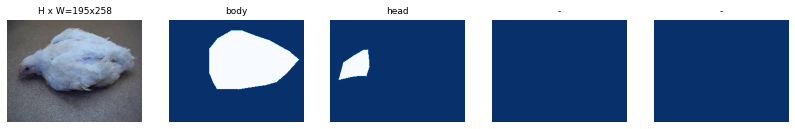

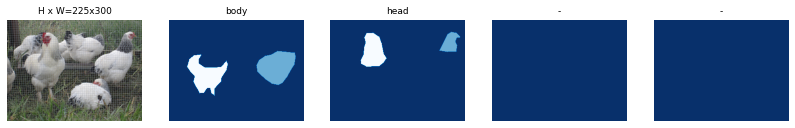

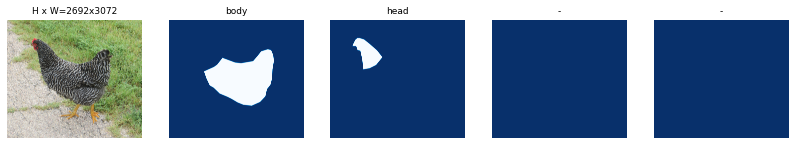

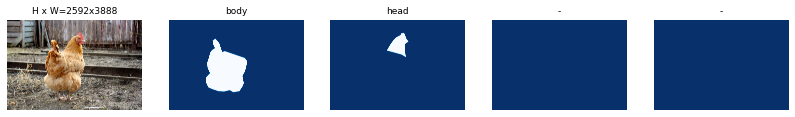

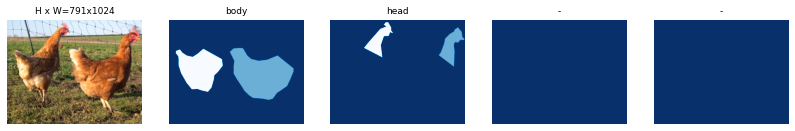

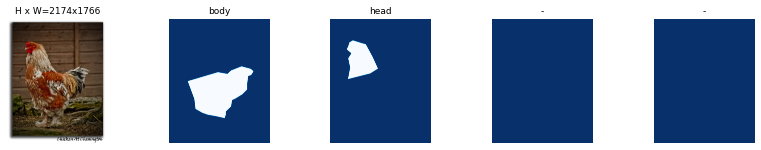

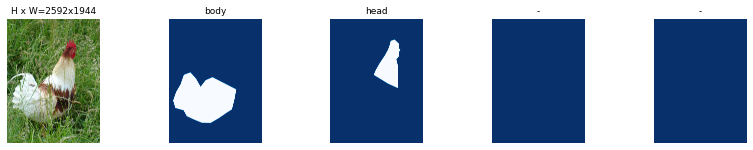

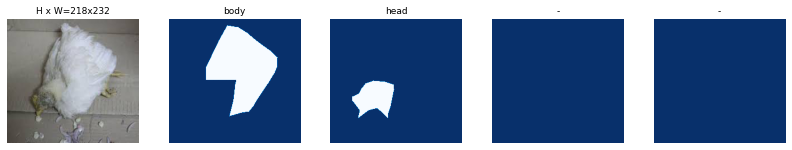

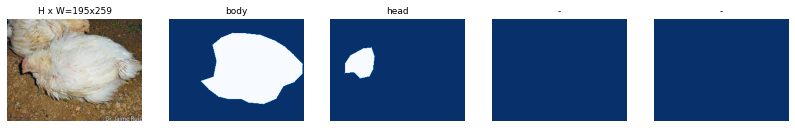

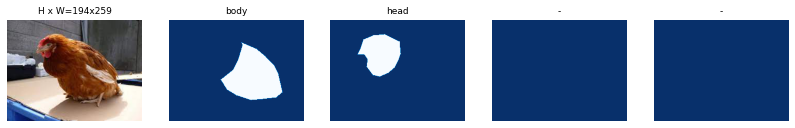

In [ ]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

    #print(mask, "and", class_ids)

    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


## Create Model

In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights
init_with = "coco"

if init_with == "coco":
  model.load_weights(COCO_MODEL_PATH, by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/object20220131T1811/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 12730s - loss: 7.0861 - rpn_class_loss: 0.0854 - rpn_bbox_loss: 2.3282 - mrcnn_class_loss: 2.9534 - mrcnn_bbox_loss: 1.1769 - mrcnn_mask_loss: 0.5421

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 9650s - loss: 5.8001 - rpn_class_loss: 0.0805 - rpn_bbox_loss: 1.7338 - mrcnn_class_loss: 2.4363 - mrcnn_bbox_loss: 1.0670 - mrcnn_mask_loss: 0.4825 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 8579s - loss: 4.8837 - rpn_class_loss: 0.0608 - rpn_bbox_loss: 1.4835 - mrcnn_class_loss: 1.8441 - mrcnn_bbox_loss: 1.0244 - mrcnn_mask_loss: 0.4709

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 8007s - loss: 4.2539 - rpn_class_loss: 0.0474 - rpn_bbox_loss: 1.3088 - mrcnn_class_loss: 1.4264 - mrcnn_bbox_loss: 0.9791 - mrcnn_mask_loss: 0.4922

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 7632s - loss: 3.9497 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 1.1291 - mrcnn_class_loss: 1.1977 - mrcnn_bbox_loss: 1.0226 - mrcnn_mask_loss: 0.5623

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 7348s - loss: 3.8072 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.1131 - mrcnn_class_loss: 1.0123 - mrcnn_bbox_loss: 1.0333 - mrcnn_mask_loss: 0.6119

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 7127s - loss: 3.5311 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 1.0234 - mrcnn_class_loss: 0.8730 - mrcnn_bbox_loss: 0.9899 - mrcnn_mask_loss: 0.6130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 6944s - loss: 3.4214 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 1.0140 - mrcnn_class_loss: 0.7899 - mrcnn_bbox_loss: 0.9622 - mrcnn_mask_loss: 0.6240

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 6781s - loss: 3.2921 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.9254 - mrcnn_class_loss: 0.7366 - mrcnn_bbox_loss: 0.9644 - mrcnn_mask_loss: 0.6379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 6637s - loss: 3.2726 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9159 - mrcnn_class_loss: 0.6869 - mrcnn_bbox_loss: 0.9913 - mrcnn_mask_loss: 0.6500

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 6516s - loss: 3.2403 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.9470 - mrcnn_class_loss: 0.6286 - mrcnn_bbox_loss: 1.0143 - mrcnn_mask_loss: 0.6222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 6399s - loss: 3.2359 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.9967 - mrcnn_class_loss: 0.5781 - mrcnn_bbox_loss: 1.0121 - mrcnn_mask_loss: 0.6195

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 6297s - loss: 3.1417 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.9550 - mrcnn_class_loss: 0.5504 - mrcnn_bbox_loss: 0.9970 - mrcnn_mask_loss: 0.6108

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 6195s - loss: 3.0441 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.9255 - mrcnn_class_loss: 0.5150 - mrcnn_bbox_loss: 0.9675 - mrcnn_mask_loss: 0.6090

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 6091s - loss: 3.0505 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.9718 - mrcnn_class_loss: 0.4907 - mrcnn_bbox_loss: 0.9568 - mrcnn_mask_loss: 0.6008

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 5995s - loss: 2.9928 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.9292 - mrcnn_class_loss: 0.4785 - mrcnn_bbox_loss: 0.9563 - mrcnn_mask_loss: 0.5995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 5907s - loss: 2.9265 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.9136 - mrcnn_class_loss: 0.4562 - mrcnn_bbox_loss: 0.9352 - mrcnn_mask_loss: 0.5932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 5818s - loss: 3.1316 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.1539 - mrcnn_class_loss: 0.4359 - mrcnn_bbox_loss: 0.9151 - mrcnn_mask_loss: 0.5853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 5731s - loss: 3.0574 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 1.1059 - mrcnn_class_loss: 0.4189 - mrcnn_bbox_loss: 0.9025 - mrcnn_mask_loss: 0.5908

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 5646s - loss: 2.9934 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 1.0733 - mrcnn_class_loss: 0.4040 - mrcnn_bbox_loss: 0.8875 - mrcnn_mask_loss: 0.5874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 5561s - loss: 3.1017 - rpn_class_loss: 0.0487 - rpn_bbox_loss: 1.2088 - mrcnn_class_loss: 0.3897 - mrcnn_bbox_loss: 0.8747 - mrcnn_mask_loss: 0.5796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 5483s - loss: 3.0426 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 1.1645 - mrcnn_class_loss: 0.3817 - mrcnn_bbox_loss: 0.8690 - mrcnn_mask_loss: 0.5807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 5405s - loss: 2.9873 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 1.1358 - mrcnn_class_loss: 0.3755 - mrcnn_bbox_loss: 0.8568 - mrcnn_mask_loss: 0.5740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 5331s - loss: 2.9131 - rpn_class_loss: 0.0442 - rpn_bbox_loss: 1.0973 - mrcnn_class_loss: 0.3632 - mrcnn_bbox_loss: 0.8404 - mrcnn_mask_loss: 0.5680

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 5260s - loss: 2.8589 - rpn_class_loss: 0.0424 - rpn_bbox_loss: 1.0661 - mrcnn_class_loss: 0.3535 - mrcnn_bbox_loss: 0.8324 - mrcnn_mask_loss: 0.5644

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 5184s - loss: 2.7963 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 1.0317 - mrcnn_class_loss: 0.3432 - mrcnn_bbox_loss: 0.8192 - mrcnn_mask_loss: 0.5607

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 5109s - loss: 2.7755 - rpn_class_loss: 0.0421 - rpn_bbox_loss: 1.0204 - mrcnn_class_loss: 0.3421 - mrcnn_bbox_loss: 0.8114 - mrcnn_mask_loss: 0.5594

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 5032s - loss: 2.7152 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.9900 - mrcnn_class_loss: 0.3325 - mrcnn_bbox_loss: 0.7986 - mrcnn_mask_loss: 0.5533

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 4958s - loss: 2.6813 - rpn_class_loss: 0.0394 - rpn_bbox_loss: 0.9651 - mrcnn_class_loss: 0.3272 - mrcnn_bbox_loss: 0.7960 - mrcnn_mask_loss: 0.5536

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 4882s - loss: 2.6566 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.9408 - mrcnn_class_loss: 0.3287 - mrcnn_bbox_loss: 0.7985 - mrcnn_mask_loss: 0.5504

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 4813s - loss: 2.6185 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.9213 - mrcnn_class_loss: 0.3215 - mrcnn_bbox_loss: 0.7932 - mrcnn_mask_loss: 0.5452

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 4741s - loss: 2.5865 - rpn_class_loss: 0.0363 - rpn_bbox_loss: 0.9033 - mrcnn_class_loss: 0.3155 - mrcnn_bbox_loss: 0.7873 - mrcnn_mask_loss: 0.5443

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 4666s - loss: 2.5409 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.8792 - mrcnn_class_loss: 0.3092 - mrcnn_bbox_loss: 0.7772 - mrcnn_mask_loss: 0.5400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 4593s - loss: 2.5060 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.8611 - mrcnn_class_loss: 0.3032 - mrcnn_bbox_loss: 0.7696 - mrcnn_mask_loss: 0.5372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 4520s - loss: 2.4667 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.8432 - mrcnn_class_loss: 0.2962 - mrcnn_bbox_loss: 0.7620 - mrcnn_mask_loss: 0.5311

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 4452s - loss: 2.4248 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.8220 - mrcnn_class_loss: 0.2917 - mrcnn_bbox_loss: 0.7505 - mrcnn_mask_loss: 0.5271

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 4379s - loss: 2.4165 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.8249 - mrcnn_class_loss: 0.2843 - mrcnn_bbox_loss: 0.7486 - mrcnn_mask_loss: 0.5256

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 4307s - loss: 2.3858 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.8091 - mrcnn_class_loss: 0.2837 - mrcnn_bbox_loss: 0.7408 - mrcnn_mask_loss: 0.5198

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 4234s - loss: 2.3510 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.7906 - mrcnn_class_loss: 0.2788 - mrcnn_bbox_loss: 0.7337 - mrcnn_mask_loss: 0.5156

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 4161s - loss: 2.3284 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 0.7835 - mrcnn_class_loss: 0.2747 - mrcnn_bbox_loss: 0.7259 - mrcnn_mask_loss: 0.5128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 4089s - loss: 2.3026 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.7672 - mrcnn_class_loss: 0.2716 - mrcnn_bbox_loss: 0.7230 - mrcnn_mask_loss: 0.5100

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 4017s - loss: 2.2814 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.7552 - mrcnn_class_loss: 0.2745 - mrcnn_bbox_loss: 0.7159 - mrcnn_mask_loss: 0.5052

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 3945s - loss: 2.2653 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.7451 - mrcnn_class_loss: 0.2702 - mrcnn_bbox_loss: 0.7170 - mrcnn_mask_loss: 0.5031

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 3873s - loss: 2.2454 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.7338 - mrcnn_class_loss: 0.2684 - mrcnn_bbox_loss: 0.7147 - mrcnn_mask_loss: 0.4990

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 3802s - loss: 2.2271 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.7211 - mrcnn_class_loss: 0.2675 - mrcnn_bbox_loss: 0.7158 - mrcnn_mask_loss: 0.4938

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 3731s - loss: 2.2058 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.7103 - mrcnn_class_loss: 0.2638 - mrcnn_bbox_loss: 0.7136 - mrcnn_mask_loss: 0.4899

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 3659s - loss: 2.1865 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.6981 - mrcnn_class_loss: 0.2621 - mrcnn_bbox_loss: 0.7134 - mrcnn_mask_loss: 0.4852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 3587s - loss: 2.1634 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6883 - mrcnn_class_loss: 0.2583 - mrcnn_bbox_loss: 0.7041 - mrcnn_mask_loss: 0.4854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 3516s - loss: 2.1419 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6786 - mrcnn_class_loss: 0.2545 - mrcnn_bbox_loss: 0.7006 - mrcnn_mask_loss: 0.4811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 3446s - loss: 2.1420 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.6827 - mrcnn_class_loss: 0.2540 - mrcnn_bbox_loss: 0.6993 - mrcnn_mask_loss: 0.4785

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 3376s - loss: 2.1426 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.6833 - mrcnn_class_loss: 0.2553 - mrcnn_bbox_loss: 0.6948 - mrcnn_mask_loss: 0.4793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 3305s - loss: 2.1349 - rpn_class_loss: 0.0294 - rpn_bbox_loss: 0.6860 - mrcnn_class_loss: 0.2512 - mrcnn_bbox_loss: 0.6913 - mrcnn_mask_loss: 0.4770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 3234s - loss: 2.1170 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.6746 - mrcnn_class_loss: 0.2479 - mrcnn_bbox_loss: 0.6906 - mrcnn_mask_loss: 0.4751

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 3164s - loss: 2.0992 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.6659 - mrcnn_class_loss: 0.2454 - mrcnn_bbox_loss: 0.6861 - mrcnn_mask_loss: 0.4735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 3093s - loss: 2.0780 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.6554 - mrcnn_class_loss: 0.2435 - mrcnn_bbox_loss: 0.6807 - mrcnn_mask_loss: 0.4705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 3024s - loss: 2.0564 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.6452 - mrcnn_class_loss: 0.2409 - mrcnn_bbox_loss: 0.6744 - mrcnn_mask_loss: 0.4685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 2954s - loss: 2.0400 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.6388 - mrcnn_class_loss: 0.2387 - mrcnn_bbox_loss: 0.6686 - mrcnn_mask_loss: 0.4669

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 2884s - loss: 2.0312 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6326 - mrcnn_class_loss: 0.2369 - mrcnn_bbox_loss: 0.6680 - mrcnn_mask_loss: 0.4670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 2814s - loss: 2.0211 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.6248 - mrcnn_class_loss: 0.2351 - mrcnn_bbox_loss: 0.6664 - mrcnn_mask_loss: 0.4681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 2745s - loss: 2.0108 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.6224 - mrcnn_class_loss: 0.2332 - mrcnn_bbox_loss: 0.6636 - mrcnn_mask_loss: 0.4654

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 2675s - loss: 1.9982 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.6154 - mrcnn_class_loss: 0.2318 - mrcnn_bbox_loss: 0.6614 - mrcnn_mask_loss: 0.4637

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 2606s - loss: 1.9803 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.6082 - mrcnn_class_loss: 0.2289 - mrcnn_bbox_loss: 0.6579 - mrcnn_mask_loss: 0.4598

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 2536s - loss: 1.9666 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.6018 - mrcnn_class_loss: 0.2276 - mrcnn_bbox_loss: 0.6554 - mrcnn_mask_loss: 0.4567

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 2467s - loss: 1.9514 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5965 - mrcnn_class_loss: 0.2245 - mrcnn_bbox_loss: 0.6518 - mrcnn_mask_loss: 0.4538

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 2398s - loss: 1.9460 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.5899 - mrcnn_class_loss: 0.2283 - mrcnn_bbox_loss: 0.6501 - mrcnn_mask_loss: 0.4529

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 2328s - loss: 1.9290 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.5837 - mrcnn_class_loss: 0.2254 - mrcnn_bbox_loss: 0.6453 - mrcnn_mask_loss: 0.4501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 2259s - loss: 1.9207 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.5775 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.6446 - mrcnn_mask_loss: 0.4500

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 2190s - loss: 1.9096 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.5729 - mrcnn_class_loss: 0.2223 - mrcnn_bbox_loss: 0.6430 - mrcnn_mask_loss: 0.4474

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 2121s - loss: 1.9047 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.5694 - mrcnn_class_loss: 0.2243 - mrcnn_bbox_loss: 0.6413 - mrcnn_mask_loss: 0.4459

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 2051s - loss: 1.8968 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.5640 - mrcnn_class_loss: 0.2229 - mrcnn_bbox_loss: 0.6415 - mrcnn_mask_loss: 0.4447

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 1982s - loss: 1.8971 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.5632 - mrcnn_class_loss: 0.2232 - mrcnn_bbox_loss: 0.6437 - mrcnn_mask_loss: 0.4436

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 1913s - loss: 1.8820 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.5562 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.6403 - mrcnn_mask_loss: 0.4415

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 1844s - loss: 1.8679 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.5509 - mrcnn_class_loss: 0.2185 - mrcnn_bbox_loss: 0.6364 - mrcnn_mask_loss: 0.4392

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 1775s - loss: 1.8717 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.5520 - mrcnn_class_loss: 0.2235 - mrcnn_bbox_loss: 0.6336 - mrcnn_mask_loss: 0.4396

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 1706s - loss: 1.8730 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.5509 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 0.6346 - mrcnn_mask_loss: 0.4403

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 1637s - loss: 1.8646 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.5463 - mrcnn_class_loss: 0.2224 - mrcnn_bbox_loss: 0.6345 - mrcnn_mask_loss: 0.4389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 1568s - loss: 1.8541 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5425 - mrcnn_class_loss: 0.2211 - mrcnn_bbox_loss: 0.6314 - mrcnn_mask_loss: 0.4368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 1499s - loss: 1.8471 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.5398 - mrcnn_class_loss: 0.2204 - mrcnn_bbox_loss: 0.6292 - mrcnn_mask_loss: 0.4354

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 1431s - loss: 1.8363 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.5349 - mrcnn_class_loss: 0.2191 - mrcnn_bbox_loss: 0.6262 - mrcnn_mask_loss: 0.4340

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 1362s - loss: 1.8320 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.5341 - mrcnn_class_loss: 0.2178 - mrcnn_bbox_loss: 0.6250 - mrcnn_mask_loss: 0.4333

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 1293s - loss: 1.8191 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.5291 - mrcnn_class_loss: 0.2158 - mrcnn_bbox_loss: 0.6217 - mrcnn_mask_loss: 0.4308

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 1225s - loss: 1.8154 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.5266 - mrcnn_class_loss: 0.2157 - mrcnn_bbox_loss: 0.6199 - mrcnn_mask_loss: 0.4316

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1156s - loss: 1.8083 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.2147 - mrcnn_bbox_loss: 0.6192 - mrcnn_mask_loss: 0.4314

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1088s - loss: 1.8047 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.5177 - mrcnn_class_loss: 0.2152 - mrcnn_bbox_loss: 0.6183 - mrcnn_mask_loss: 0.4323

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1019s - loss: 1.7984 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.5139 - mrcnn_class_loss: 0.2146 - mrcnn_bbox_loss: 0.6192 - mrcnn_mask_loss: 0.4296

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 951s - loss: 1.7928 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.5132 - mrcnn_class_loss: 0.2131 - mrcnn_bbox_loss: 0.6174 - mrcnn_mask_loss: 0.4281 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 883s - loss: 1.7886 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.5107 - mrcnn_class_loss: 0.2122 - mrcnn_bbox_loss: 0.6173 - mrcnn_mask_loss: 0.4276

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 814s - loss: 1.7853 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.5093 - mrcnn_class_loss: 0.2124 - mrcnn_bbox_loss: 0.6169 - mrcnn_mask_loss: 0.4261

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 746s - loss: 1.7790 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5079 - mrcnn_class_loss: 0.2114 - mrcnn_bbox_loss: 0.6143 - mrcnn_mask_loss: 0.4248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 678s - loss: 1.7714 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.5035 - mrcnn_class_loss: 0.2116 - mrcnn_bbox_loss: 0.6118 - mrcnn_mask_loss: 0.4240

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 610s - loss: 1.7637 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4991 - mrcnn_class_loss: 0.2105 - mrcnn_bbox_loss: 0.6111 - mrcnn_mask_loss: 0.4228

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 542s - loss: 1.7570 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4969 - mrcnn_class_loss: 0.2087 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.4213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 474s - loss: 1.7556 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.4965 - mrcnn_class_loss: 0.2086 - mrcnn_bbox_loss: 0.6109 - mrcnn_mask_loss: 0.4198

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 406s - loss: 1.7495 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4942 - mrcnn_class_loss: 0.2072 - mrcnn_bbox_loss: 0.6092 - mrcnn_mask_loss: 0.4192

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 338s - loss: 1.7413 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.4913 - mrcnn_class_loss: 0.2064 - mrcnn_bbox_loss: 0.6053 - mrcnn_mask_loss: 0.4189

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 270s - loss: 1.7405 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.4914 - mrcnn_class_loss: 0.2081 - mrcnn_bbox_loss: 0.6037 - mrcnn_mask_loss: 0.4180

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 202s - loss: 1.7330 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.4899 - mrcnn_class_loss: 0.2066 - mrcnn_bbox_loss: 0.6006 - mrcnn_mask_loss: 0.4166

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 135s - loss: 1.7276 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.4868 - mrcnn_class_loss: 0.2061 - mrcnn_bbox_loss: 0.5980 - mrcnn_mask_loss: 0.4174

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 67s - loss: 1.7179 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.2049 - mrcnn_bbox_loss: 0.5939 - mrcnn_mask_loss: 0.4163 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
 

100/100 [==============================] - 8185s - loss: 1.7088 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.4808 - mrcnn_class_loss: 0.2035 - mrcnn_bbox_loss: 0.5913 - mrcnn_mask_loss: 0.4140 - val_loss: 1.3190 - val_rpn_class_loss: 0.0126 - val_rpn_bbox_loss: 0.3586 - val_mrcnn_class_loss: 0.1202 - val_mrcnn_bbox_loss: 0.4937 - val_mrcnn_mask_loss: 0.3339


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/logs/object20220131T1811/mask_rcnn_object_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b         

/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/100 [..............................] - ETA: 17667s - loss: 1.6216 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.6172 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.6134 - mrcnn_mask_loss: 0.2830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/100 [..............................] - ETA: 13367s - loss: 1.4624 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.4768 - mrcnn_class_loss: 0.1322 - mrcnn_bbox_loss: 0.4927 - mrcnn_mask_loss: 0.3441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/100 [..............................] - ETA: 11829s - loss: 1.4068 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.3944 - mrcnn_class_loss: 0.1112 - mrcnn_bbox_loss: 0.5641 - mrcnn_mask_loss: 0.3250

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/100 [>.............................] - ETA: 10982s - loss: 1.3212 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.3472 - mrcnn_class_loss: 0.1116 - mrcnn_bbox_loss: 0.5390 - mrcnn_mask_loss: 0.3136

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/100 [>.............................] - ETA: 10439s - loss: 1.2798 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3010 - mrcnn_class_loss: 0.0981 - mrcnn_bbox_loss: 0.5493 - mrcnn_mask_loss: 0.3206

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/100 [>.............................] - ETA: 10065s - loss: 1.1894 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2812 - mrcnn_class_loss: 0.0980 - mrcnn_bbox_loss: 0.5012 - mrcnn_mask_loss: 0.2998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/100 [=>............................] - ETA: 9757s - loss: 1.1483 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2719 - mrcnn_class_loss: 0.0991 - mrcnn_bbox_loss: 0.4706 - mrcnn_mask_loss: 0.2982 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/100 [=>............................] - ETA: 9516s - loss: 1.1054 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.0953 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.2921

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/100 [=>............................] - ETA: 9299s - loss: 1.0781 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.4342 - mrcnn_mask_loss: 0.2883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/100 [==>...........................] - ETA: 9119s - loss: 1.0862 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.4531 - mrcnn_mask_loss: 0.2873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/100 [==>...........................] - ETA: 8948s - loss: 1.0974 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2484 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.4620 - mrcnn_mask_loss: 0.2796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/100 [==>...........................] - ETA: 8790s - loss: 1.0758 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.4550 - mrcnn_mask_loss: 0.2757

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/100 [==>...........................] - ETA: 8645s - loss: 1.0854 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.4461 - mrcnn_mask_loss: 0.2853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/100 [===>..........................] - ETA: 8506s - loss: 1.0758 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.1155 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.2878

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/100 [===>..........................] - ETA: 8387s - loss: 1.0572 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.1137 - mrcnn_bbox_loss: 0.4274 - mrcnn_mask_loss: 0.2845

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/100 [===>..........................] - ETA: 8258s - loss: 1.0792 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2282 - mrcnn_class_loss: 0.1149 - mrcnn_bbox_loss: 0.4427 - mrcnn_mask_loss: 0.2858

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/100 [====>.........................] - ETA: 8134s - loss: 1.0873 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2331 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.4386 - mrcnn_mask_loss: 0.2868

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/100 [====>.........................] - ETA: 8010s - loss: 1.0710 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.2902

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/100 [====>.........................] - ETA: 7888s - loss: 1.0759 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.1295 - mrcnn_bbox_loss: 0.4203 - mrcnn_mask_loss: 0.2919

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/100 [=====>........................] - ETA: 7764s - loss: 1.0820 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2213 - mrcnn_class_loss: 0.1306 - mrcnn_bbox_loss: 0.4245 - mrcnn_mask_loss: 0.2970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/100 [=====>........................] - ETA: 7645s - loss: 1.0644 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.1265 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.2953

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/100 [=====>........................] - ETA: 7533s - loss: 1.0503 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2198 - mrcnn_class_loss: 0.1242 - mrcnn_bbox_loss: 0.4035 - mrcnn_mask_loss: 0.2947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/100 [=====>........................] - ETA: 7420s - loss: 1.0351 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.2923

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/100 [======>.......................] - ETA: 7308s - loss: 1.0197 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.3885 - mrcnn_mask_loss: 0.2922

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/100 [======>.......................] - ETA: 7199s - loss: 1.0051 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.1193 - mrcnn_bbox_loss: 0.3825 - mrcnn_mask_loss: 0.2895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/100 [======>.......................] - ETA: 7089s - loss: 0.9948 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2054 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.2874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/100 [=======>......................] - ETA: 6983s - loss: 1.0011 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2088 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.3764 - mrcnn_mask_loss: 0.2900

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/100 [=======>......................] - ETA: 6877s - loss: 1.0082 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.1209 - mrcnn_bbox_loss: 0.3763 - mrcnn_mask_loss: 0.2968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/100 [=======>......................] - ETA: 6771s - loss: 1.0123 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2119 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.3768 - mrcnn_mask_loss: 0.2967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/100 [========>.....................] - ETA: 6668s - loss: 1.0006 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2100 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.3692 - mrcnn_mask_loss: 0.2954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/100 [========>.....................] - ETA: 6566s - loss: 0.9980 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.1173 - mrcnn_bbox_loss: 0.3656 - mrcnn_mask_loss: 0.2952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/100 [========>.....................] - ETA: 6465s - loss: 0.9982 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.3641 - mrcnn_mask_loss: 0.2930

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/100 [========>.....................] - ETA: 6363s - loss: 0.9890 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.1199 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.2906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/100 [=========>....................] - ETA: 6262s - loss: 0.9980 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.3681 - mrcnn_mask_loss: 0.2925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/100 [=========>....................] - ETA: 6164s - loss: 1.0025 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2129 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.3665 - mrcnn_mask_loss: 0.2920

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/100 [=========>....................] - ETA: 6063s - loss: 1.0031 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.1264 - mrcnn_bbox_loss: 0.3642 - mrcnn_mask_loss: 0.2924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/100 [==========>...................] - ETA: 5966s - loss: 1.0007 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2121 - mrcnn_class_loss: 0.1278 - mrcnn_bbox_loss: 0.3624 - mrcnn_mask_loss: 0.2906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/100 [==========>...................] - ETA: 5867s - loss: 0.9990 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.1268 - mrcnn_bbox_loss: 0.3623 - mrcnn_mask_loss: 0.2915

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/100 [==========>...................] - ETA: 5769s - loss: 0.9906 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2074 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.3581 - mrcnn_mask_loss: 0.2917

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/100 [===========>..................] - ETA: 5672s - loss: 0.9900 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2084 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.3568 - mrcnn_mask_loss: 0.2931

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/100 [===========>..................] - ETA: 5574s - loss: 0.9923 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.3561 - mrcnn_mask_loss: 0.2967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/100 [===========>..................] - ETA: 5477s - loss: 0.9857 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2028 - mrcnn_class_loss: 0.1254 - mrcnn_bbox_loss: 0.3534 - mrcnn_mask_loss: 0.2964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/100 [===========>..................] - ETA: 5381s - loss: 0.9863 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2028 - mrcnn_class_loss: 0.1249 - mrcnn_bbox_loss: 0.3546 - mrcnn_mask_loss: 0.2961

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/100 [============>.................] - ETA: 5283s - loss: 0.9840 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.1241 - mrcnn_bbox_loss: 0.3512 - mrcnn_mask_loss: 0.2957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/100 [============>.................] - ETA: 5186s - loss: 0.9792 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2033 - mrcnn_class_loss: 0.1229 - mrcnn_bbox_loss: 0.3491 - mrcnn_mask_loss: 0.2960

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/100 [============>.................] - ETA: 5090s - loss: 0.9765 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.1228 - mrcnn_bbox_loss: 0.3464 - mrcnn_mask_loss: 0.2965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/100 [=============>................] - ETA: 4993s - loss: 0.9730 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2030 - mrcnn_class_loss: 0.1219 - mrcnn_bbox_loss: 0.3442 - mrcnn_mask_loss: 0.2964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/100 [=============>................] - ETA: 4894s - loss: 0.9774 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.1237 - mrcnn_bbox_loss: 0.3448 - mrcnn_mask_loss: 0.2983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/100 [=============>................] - ETA: 4799s - loss: 0.9685 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.3416 - mrcnn_mask_loss: 0.2967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/100 [==============>...............] - ETA: 4702s - loss: 0.9678 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.3402 - mrcnn_mask_loss: 0.2971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/100 [==============>...............] - ETA: 4606s - loss: 0.9627 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.1225 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.2975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/100 [==============>...............] - ETA: 4511s - loss: 0.9560 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1981 - mrcnn_class_loss: 0.1219 - mrcnn_bbox_loss: 0.3332 - mrcnn_mask_loss: 0.2954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/100 [==============>...............] - ETA: 4417s - loss: 0.9535 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.2959

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/100 [===============>..............] - ETA: 4322s - loss: 0.9559 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.1235 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.2955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/100 [===============>..............] - ETA: 4227s - loss: 0.9543 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1986 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.2955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/100 [===============>..............] - ETA: 4132s - loss: 0.9504 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.1223 - mrcnn_bbox_loss: 0.3301 - mrcnn_mask_loss: 0.2951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/100 [================>.............] - ETA: 4037s - loss: 0.9466 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1943 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.3288 - mrcnn_mask_loss: 0.2949

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/100 [================>.............] - ETA: 3942s - loss: 0.9397 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1925 - mrcnn_class_loss: 0.1200 - mrcnn_bbox_loss: 0.3265 - mrcnn_mask_loss: 0.2939

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/100 [================>.............] - ETA: 3847s - loss: 0.9322 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.1190 - mrcnn_bbox_loss: 0.3235 - mrcnn_mask_loss: 0.2920

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/100 [=================>............] - ETA: 3752s - loss: 0.9305 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.1176 - mrcnn_bbox_loss: 0.3223 - mrcnn_mask_loss: 0.2909

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/100 [=================>............] - ETA: 3658s - loss: 0.9259 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.1172 - mrcnn_bbox_loss: 0.3198 - mrcnn_mask_loss: 0.2901

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/100 [=================>............] - ETA: 3563s - loss: 0.9329 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.1192 - mrcnn_bbox_loss: 0.3203 - mrcnn_mask_loss: 0.2907

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/100 [=================>............] - ETA: 3469s - loss: 0.9307 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.2919

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/100 [==================>...........] - ETA: 3374s - loss: 0.9285 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.1179 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.2917

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/100 [==================>...........] - ETA: 3279s - loss: 0.9354 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1974 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.3182 - mrcnn_mask_loss: 0.2922

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/100 [==================>...........] - ETA: 3185s - loss: 0.9379 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.3176 - mrcnn_mask_loss: 0.2927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/100 [===================>..........] - ETA: 3090s - loss: 0.9372 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.2935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/100 [===================>..........] - ETA: 2995s - loss: 0.9367 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1951 - mrcnn_class_loss: 0.1230 - mrcnn_bbox_loss: 0.3170 - mrcnn_mask_loss: 0.2942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/100 [===================>..........] - ETA: 2901s - loss: 0.9424 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.1244 - mrcnn_bbox_loss: 0.3171 - mrcnn_mask_loss: 0.2962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/100 [====================>.........] - ETA: 2806s - loss: 0.9411 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1970 - mrcnn_class_loss: 0.1240 - mrcnn_bbox_loss: 0.3162 - mrcnn_mask_loss: 0.2965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/100 [====================>.........] - ETA: 2712s - loss: 0.9404 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1958 - mrcnn_class_loss: 0.1234 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.2967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/100 [====================>.........] - ETA: 2618s - loss: 0.9341 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1944 - mrcnn_class_loss: 0.1227 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.2950

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/100 [====================>.........] - ETA: 2524s - loss: 0.9317 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.3126 - mrcnn_mask_loss: 0.2942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/100 [=====================>........] - ETA: 2429s - loss: 0.9273 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1945 - mrcnn_class_loss: 0.1206 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.2943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/100 [=====================>........] - ETA: 2335s - loss: 0.9259 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1939 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.3096 - mrcnn_mask_loss: 0.2946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/100 [=====================>........] - ETA: 2241s - loss: 0.9216 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.3076 - mrcnn_mask_loss: 0.2945

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/100 [======================>.......] - ETA: 2147s - loss: 0.9183 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1903 - mrcnn_class_loss: 0.1198 - mrcnn_bbox_loss: 0.3065 - mrcnn_mask_loss: 0.2941

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/100 [======================>.......] - ETA: 2053s - loss: 0.9220 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.1211 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.2954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/100 [======================>.......] - ETA: 1959s - loss: 0.9239 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.3054 - mrcnn_mask_loss: 0.2979

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/100 [=======================>......] - ETA: 1866s - loss: 0.9209 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.2966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/100 [=======================>......] - ETA: 1772s - loss: 0.9164 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.3033 - mrcnn_mask_loss: 0.2963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/100 [=======================>......] - ETA: 1678s - loss: 0.9138 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1878 - mrcnn_class_loss: 0.1207 - mrcnn_bbox_loss: 0.3019 - mrcnn_mask_loss: 0.2956

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/100 [=======================>......] - ETA: 1585s - loss: 0.9096 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1872 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.2997 - mrcnn_mask_loss: 0.2942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/100 [========================>.....] - ETA: 1491s - loss: 0.9107 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.2987 - mrcnn_mask_loss: 0.2963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/100 [========================>.....] - ETA: 1397s - loss: 0.9088 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1852 - mrcnn_class_loss: 0.1217 - mrcnn_bbox_loss: 0.2979 - mrcnn_mask_loss: 0.2962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/100 [========================>.....] - ETA: 1304s - loss: 0.9069 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1847 - mrcnn_class_loss: 0.1218 - mrcnn_bbox_loss: 0.2975 - mrcnn_mask_loss: 0.2951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/100 [=========================>....] - ETA: 1211s - loss: 0.9024 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.2938

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/100 [=========================>....] - ETA: 1117s - loss: 0.9013 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.2936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/100 [=========================>....] - ETA: 1024s - loss: 0.9035 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.2960 - mrcnn_mask_loss: 0.2948

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/100 [==========================>...] - ETA: 931s - loss: 0.9035 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1830 - mrcnn_class_loss: 0.1212 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.2956 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/100 [==========================>...] - ETA: 837s - loss: 0.9001 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1817 - mrcnn_class_loss: 0.1213 - mrcnn_bbox_loss: 0.2947 - mrcnn_mask_loss: 0.2951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/100 [==========================>...] - ETA: 744s - loss: 0.8977 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.1210 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.2951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/100 [==========================>...] - ETA: 651s - loss: 0.8963 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.1202 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.2952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/100 [===========================>..] - ETA: 558s - loss: 0.9015 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.2952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/100 [===========================>..] - ETA: 465s - loss: 0.8984 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.1201 - mrcnn_bbox_loss: 0.2924 - mrcnn_mask_loss: 0.2941

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/100 [===========================>..] - ETA: 371s - loss: 0.8943 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1832 - mrcnn_class_loss: 0.1197 - mrcnn_bbox_loss: 0.2911 - mrcnn_mask_loss: 0.2930

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/100 [============================>.] - ETA: 278s - loss: 0.8928 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1843 - mrcnn_class_loss: 0.1191 - mrcnn_bbox_loss: 0.2894 - mrcnn_mask_loss: 0.2928

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/100 [============================>.] - ETA: 185s - loss: 0.8902 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.1185 - mrcnn_bbox_loss: 0.2877 - mrcnn_mask_loss: 0.2926

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/100 [============================>.] - ETA: 92s - loss: 0.8921 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.1183 - mrcnn_bbox_loss: 0.2890 - mrcnn_mask_loss: 0.2931 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2142: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
 

100/100 [==============================] - 10660s - loss: 0.8958 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.1181 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.2930 - val_loss: 1.1123 - val_rpn_class_loss: 0.0150 - val_rpn_bbox_loss: 0.2863 - val_mrcnn_class_loss: 0.1253 - val_mrcnn_bbox_loss: 0.3625 - val_mrcnn_mask_loss: 0.3231


In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
print(MODEL_DIR)
print(os.listdir(MODEL_DIR))
model_path = os.path.join(MODEL_DIR, "mask_rcnn_object.h5")
model.keras_model.save_weights(model_path)




/content/logs
['object20220131T1811', 'mask_rcnn_chicken.h5']


In [ ]:
# uncomment this to save the weights in your drive
#this one takes quite a long time
#MODEL_DIR_drive = '../drive/My Drive'
#model_path = os.path.join(MODEL_DIR_drive, "mask_rcnn_object1.h5")
#model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ObjectConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use tf.cast instead.
Loading weights from  /content/logs/object20220131T1811/mask_rcnn_object_0001.h5
Re-starting from epoch 1


# Testing on a random image

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  247.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (2, 4)                min:  101.00000  max:  938.00000  int32
gt_mask                  shape: (1024, 1024, 2)       min:    0.00000  max:    1.00000  uint8


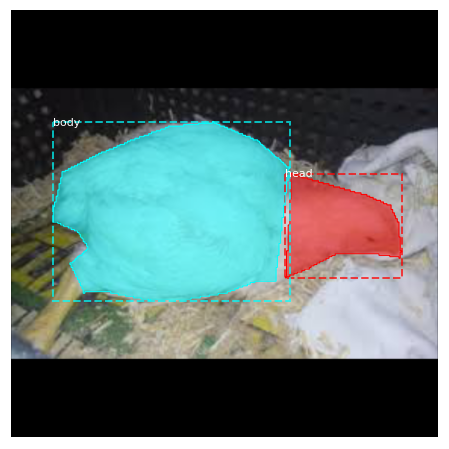

In [ ]:
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


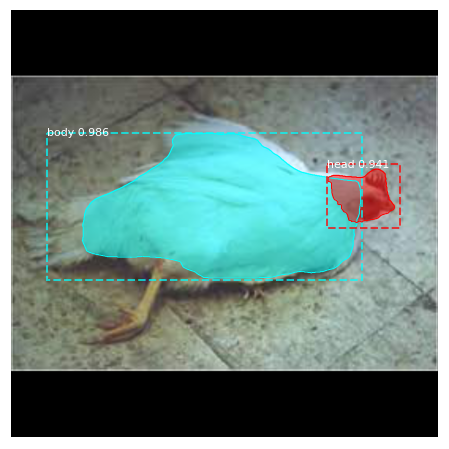

In [ ]:
###RESULTS###
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [ ]:
results = model.detect([original_image], verbose=0)
r = results[0]
print(r['rois'])

[[446 368 790 868]
 [312 324 555 503]]
y1 x1 y2 x2


# Test on a random image

Processing 1 images
image                    shape: (1536, 2048, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


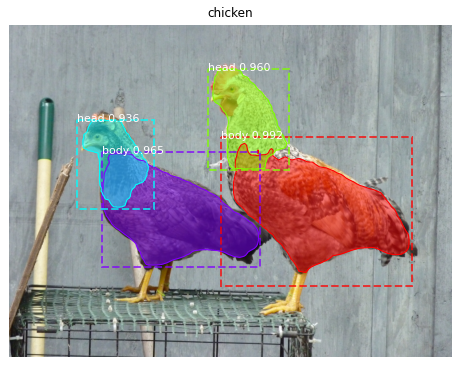

In [ ]:
new_image_path = '/content/drive/MyDrive/Real_dataset/train/20.jpg'
image = mpimg.imread(new_image_path)

results1 = model.detect([image], verbose=1)
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image, r1['rois'], r1['masks'], r1['class_ids'],
dataset_val.class_names, r1['scores'], ax=ax, title="chicken")


In [ ]:
results = model.detect([image], verbose=0)
r = results[0]
print(r['rois'])

[[ 328  373  795 1055]
 [  88  404  415  616]]


## K-means clustring

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/relativity.csv")
df.head()

,Status,Xr,Yr
0,1,0.34436,0.39549
1,1,0.30335,0.38099
2,1,0.33390,0.45461
3,0,0.45960,0.01313
4,0,0.42910,0.22000


Text(0, 0.5, 'Yr')

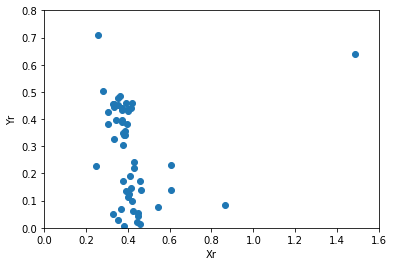

In [ ]:
plt.scatter(df.Xr,df['Yr'])
plt.xlim(0, 1.6)
plt.ylim(0, 0.8)
plt.xlabel('Xr')
plt.ylabel('Yr')

In [ ]:
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(df[['Xr','Yr']])
y_predicted

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32)

In [ ]:
df['cluster']=y_predicted
df.head()

,Status,Xr,Yr,cluster
0,1,0.34436,0.39549,0
1,1,0.30335,0.38099,0
2,1,0.33390,0.45461,0
3,0,0.45960,0.01313,1
4,0,0.42910,0.22000,1


In [ ]:
km.cluster_centers_

array([[0.40006679, 0.43232786],
       [0.4452708 , 0.1144008 ]])

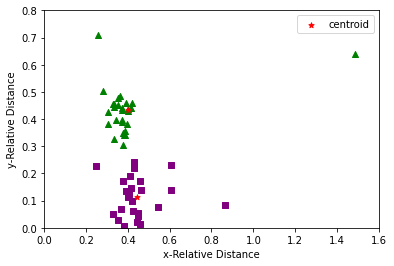

In [ ]:
df1 = df[df.cluster==0]
df2 = df[df.cluster==1]
#df3 = df[df.cluster==2]
plt.scatter(df1.Xr,df1['Yr'],color='green', marker='^')
plt.scatter(df2.Xr,df2['Yr'],color='purple', marker=',')
#plt.scatter(df3.Age,df3['Income($)'],color='black')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],s=30,color='red',marker='*',label='centroid')
plt.xlim(0, 1.6)
plt.ylim(0, 0.8)
plt.xlabel('x-Relative Distance')
plt.ylabel('y-Relative Distance')
plt.legend(loc='best')

Elbow plot

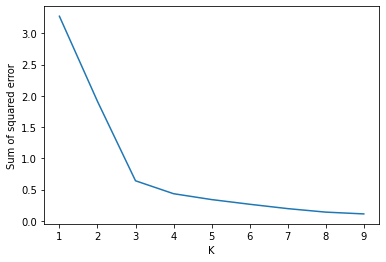

In [ ]:
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['Xr','Yr']])
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.6833333333333333
